In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.data.utilities import get_fcs_file_paths
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.data.mongo_setup import pd_test_init
import warnings
warnings.filterwarnings('ignore')
pd_test_init()

In [3]:
t = FCSExperiment.objects(experiment_id='PD_T').get()

<h1>Applying T Template to PBMCs</h1>

<h2>Populate database</h2>

In [4]:
root_dir = '/media/ross/FCS_DATA/PD_DSFriendly'
stable = [23904, 26402, 29403]
peri = [26702, 31501, '30802R']

In [5]:
stable_tfiles = dict()
for x in stable:
    d = f'{root_dir}/Stable/{x}/PBMC/TPanel'
    ctrls = ['CXCR3', 'CCR7', 'CD45RA', 'CD27']
    stable_tfiles[x] = get_fcs_file_paths(d, control_names=ctrls, ctrl_id='FMO')

In [5]:
peri_tfiles = dict()
for x in peri:
    d = f'{root_dir}/Peri/{x}/PBMC/TPanel'
    ctrls = ['CXCR3', 'CCR7', 'CD45RA', 'CD27']
    peri_tfiles[x] = get_fcs_file_paths(d, control_names=ctrls, ctrl_id='FMO')

In [6]:
for x, files in stable_tfiles.items():
    t.add_new_sample(sample_id=f'{x}_stable_pbmc', file_path=files['primary'][0], controls=files['controls'],
                    feedback=True)

Error: a file group with id 23904_stable_pbmc already exists
Error: a file group with id 26402_stable_pbmc already exists
Error: a file group with id 29403_stable_pbmc already exists


In [7]:
for x, files in peri_tfiles.items():
    t.add_new_sample(sample_id=f'{x}_peri_pbmc', file_path=files['primary'][0], controls=files['controls'],
                    feedback=True)

Error: a file group with id 26702_peri_pbmc already exists
Error: a file group with id 31501_peri_pbmc already exists
Error: a file group with id 30802R_peri_pbmc already exists


<h2>Generate a gating Template</h2>

In [34]:
pdt = Template(t, '31501_peri_pbmc')

In [38]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('lymphocytes', definition='+')
child_populations.add_population('debris', definition='-')
pre_filter = dict(xmin=20000, xmax=125000, ymin=5000, ymax=65000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 25000), k=4, conf=0.99, 
                       transform_x=None, transform_y=None, rect_filter=pre_filter)
pdt.create_gate(gate_name='gmm_lympho', parent='root', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

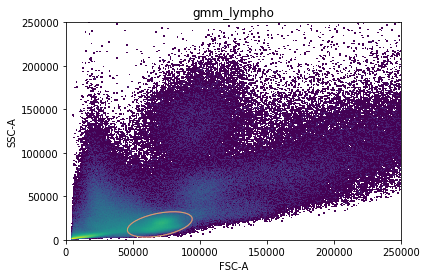

In [39]:
pdt.apply('gmm_lympho')

In [40]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('singlets1', definition='+')
child_populations.add_population('doublets1', definition='-')
gate_definition = dict(x='FSC-A', y='FSC-H', target=(70000, 25000), k=1, conf=0.99, 
                       transform_x=None, transform_y=None, rect_filter=pre_filter)
pdt.create_gate(gate_name='gmm_singlets', parent='lymphocytes', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

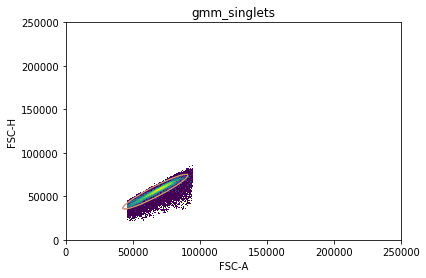

In [41]:
pdt.apply('gmm_singlets')

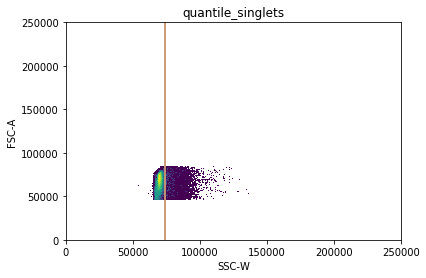

In [42]:
child_populations = ChildPopulationCollection('threshold_1d')
child_populations.add_population('doublets2', definition='+')
child_populations.add_population('singlets2', definition='-')
gate_definition = dict(x='SSC-W', y='FSC-A', q=0.95, transform_x=None, transform_y=None)
pdt.create_gate(gate_name='quantile_singlets', parent='singlets1', class_='Quantile', method='gate_1d',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('quantile_singlets')

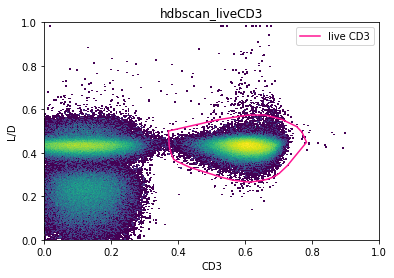

In [45]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('live CD3', target=(0.6, 0.4), weight=1)
gate_definition = dict(x='CD3', y='L/D', frac=0.1, min_pop_size=100)
pdt.create_gate(gate_name='hdbscan_liveCD3', parent='singlets2', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('hdbscan_liveCD3')

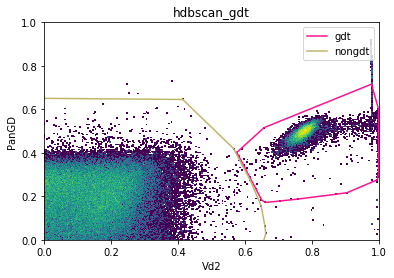

In [46]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('gdt', target=(0.8, 0.6), weight=2)
child_populations.add_population('nongdt', target=(0.2, 0.2), weight=2)
gate_definition = dict(x='Vd2', y='PanGD', frac=0.2, min_pop_size=50, downsample_method='density')
pdt.create_gate(gate_name='hdbscan_gdt', parent='live CD3', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('hdbscan_gdt')

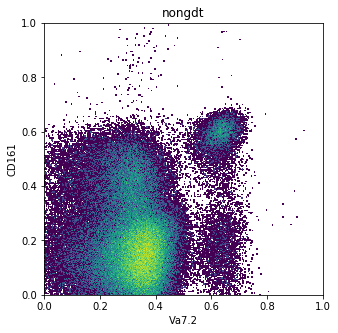

In [24]:
pdt.plotting.plot_population('nongdt', 'Va7.2', 'CD161', transform_x='logicle', transform_y='logicle')

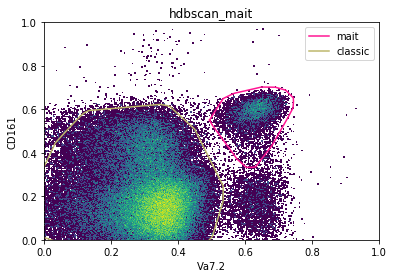

In [47]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('mait', target=(0.7, 0.6), weight=2)
child_populations.add_population('classic', target=(0.3, 0.2), weight=1)
gate_definition = dict(x='Va7.2', y='CD161', frac=0.2, min_pop_size=50, downsample_method='density')
pdt.create_gate(gate_name='hdbscan_mait', parent='nongdt', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('hdbscan_mait')

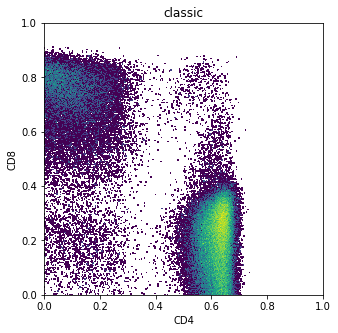

In [26]:
pdt.plotting.plot_population('classic', 'CD4', 'CD8', transform_x='logicle', transform_y='logicle')

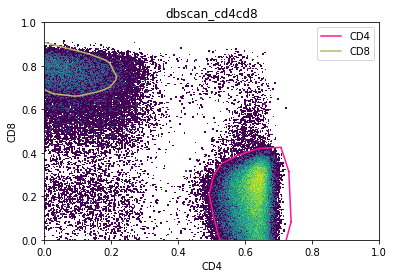

In [48]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('CD4', target=(0.6, 0.2), weight=2)
child_populations.add_population('CD8', target=(0.2, 0.8), weight=1)
gate_definition = dict(x='CD4', y='CD8', frac=0.2, min_pop_size=100, distance_nn=0.02)
pdt.create_gate(gate_name='dbscan_cd4cd8', parent='classic', class_='DensityBasedClustering', method='dbscan',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('dbscan_cd4cd8')

In [49]:
pdt.save(overwrite=True)

Saved successfully!


True

In [50]:
pdt.save_new_template('PD T Panel')

Overwriting existing gating template PD T Panel


True

<h3>Apply template to remaining samples</h3>

In [4]:
pdt = Template(t, '30802R_peri_pbmc')

In [5]:
pdt.load_template('PD T Panel')

True

In [6]:
pdt.gates

{'gmm_lympho': <Gate: Gate object>,
 'gmm_singlets': <Gate: Gate object>,
 'quantile_singlets': <Gate: Gate object>,
 'hdbscan_liveCD3': <Gate: Gate object>,
 'hdbscan_gdt': <Gate: Gate object>,
 'hdbscan_mait': <Gate: Gate object>,
 'dbscan_cd4cd8': <Gate: Gate object>}

In [7]:
pdt.apply_many(apply_all=True, plot_outcome=True, feedback=True)

User has chosen to apply all gates on a file with existing populations, when using the `apply_all` command files should have no existing populations. Remove existing populations from file before continuing. Aborting.


In [9]:
pdt.save()

Saved successfully!


True

In [34]:
pdt = Template(t, '23904_stable_pbmc')

In [35]:
pdt.load_template('PD T Panel')

True

In [36]:
pdt.gates

{'gmm_lympho': <Gate: Gate object>,
 'gmm_singlets': <Gate: Gate object>,
 'quantile_singlets': <Gate: Gate object>,
 'hdbscan_liveCD3': <Gate: Gate object>,
 'hdbscan_gdt': <Gate: Gate object>,
 'hdbscan_mait': <Gate: Gate object>,
 'dbscan_cd4cd8': <Gate: Gate object>}

In [37]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('lymphocytes', definition='+')
child_populations.add_population('debris', definition='-')
pre_filter = dict(xmin=35000, xmax=90000, ymin=5000, ymax=45000)
gate_definition = dict(x='FSC-A', y='SSC-A', k=2, algo='gmm', rect_filter=pre_filter,
                      transform_x=None, transform_y=None, target=(50000, 25000))
pdt.create_gate(gate_name='gmm3_lympho', parent='root', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

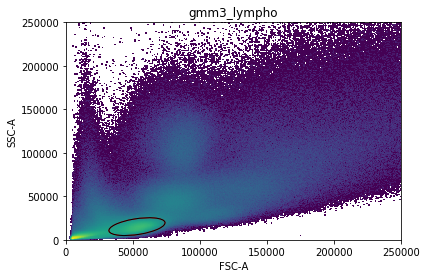

In [38]:
pdt.apply('gmm3_lympho')

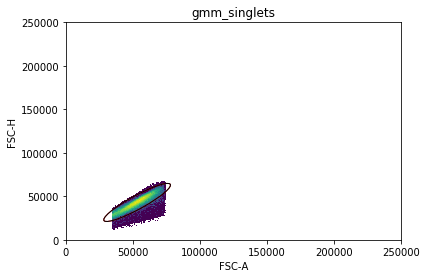

In [39]:
pdt.apply('gmm_singlets')

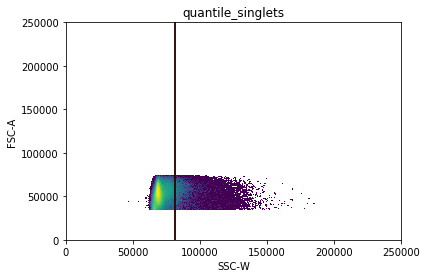

In [40]:
pdt.apply('quantile_singlets')

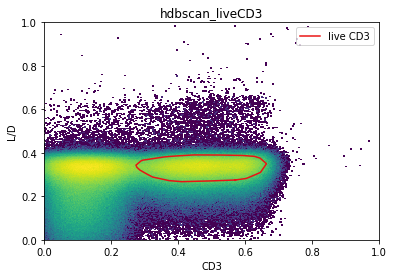

In [41]:
pdt.apply('hdbscan_liveCD3')

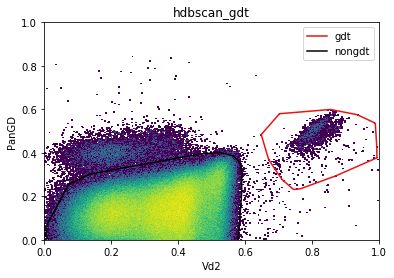

In [42]:
pdt.apply('hdbscan_gdt')

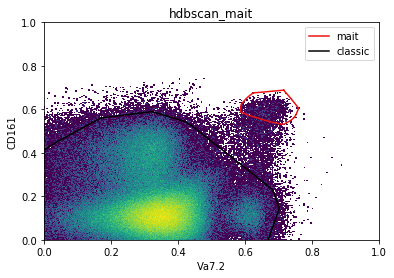

In [43]:
pdt.apply('hdbscan_mait')

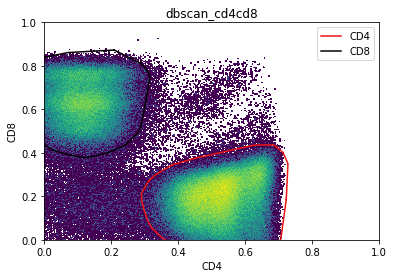

In [44]:
pdt.apply('dbscan_cd4cd8')

In [45]:
pdt.save(overwrite=True)

Saved successfully!


True

In [47]:
pdt = Template(t, '26702_peri_pbmc')

In [50]:
pdt.load_template('PD T Panel')

True

In [52]:
pdt.gates

{'gmm_lympho': <Gate: Gate object>,
 'gmm_singlets': <Gate: Gate object>,
 'quantile_singlets': <Gate: Gate object>,
 'hdbscan_liveCD3': <Gate: Gate object>,
 'hdbscan_gdt': <Gate: Gate object>,
 'hdbscan_mait': <Gate: Gate object>,
 'dbscan_cd4cd8': <Gate: Gate object>}

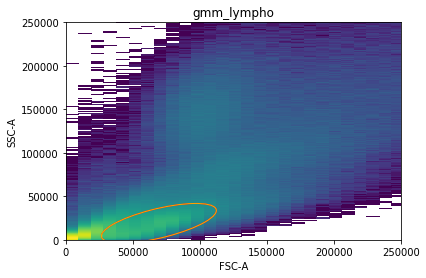

In [53]:
pdt.apply('gmm_lympho')

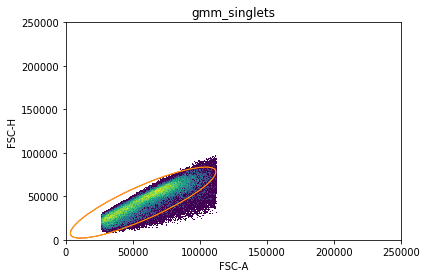

In [54]:
pdt.apply('gmm_singlets')

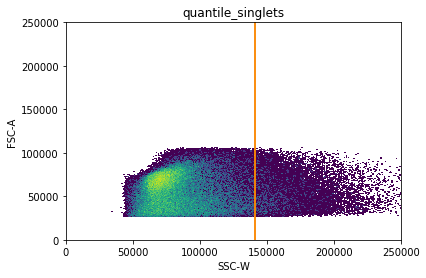

In [55]:
pdt.apply('quantile_singlets')

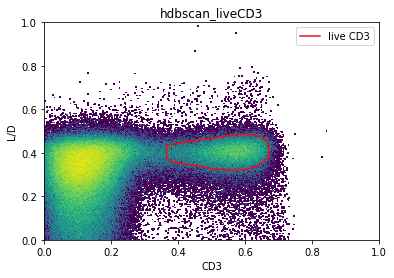

In [56]:
pdt.apply('hdbscan_liveCD3')

In [67]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('gdt', definition='+')
child_populations.add_population('nongdt', definition='-')
gate_definition = dict(x='Vd2', y='PanGD', x_min=0.6, x_max=1, y_min=0.4, y_max=1)
pdt.create_gate(gate_name='manual_gdt', parent='live CD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

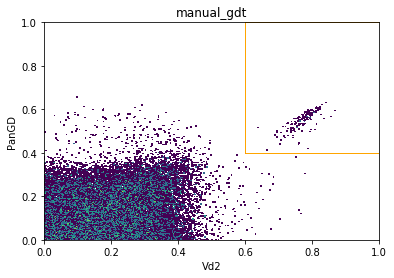

In [68]:
pdt.apply('manual_gdt')

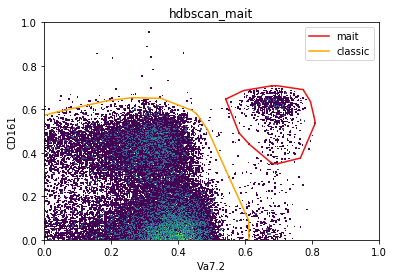

In [70]:
pdt.apply('hdbscan_mait')

In [74]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('CD4', target=(0.6, 0.2), weight=1)
child_populations.add_population('CD8', target=(0.2, 0.7), weight=1)
gate_definition = dict(x='CD4', y='CD8', min_pop_size=100)
pdt.create_gate(gate_name='hdbscan_cd4cd8', parent='classic', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)

True

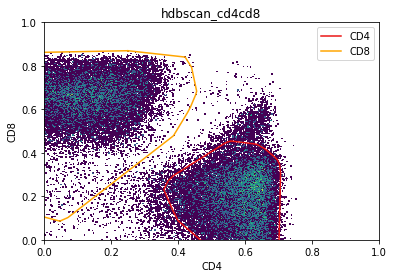

In [75]:
pdt.apply('hdbscan_cd4cd8')

In [76]:
pdt = Template(t, '26402_stable_pbmc')

In [77]:
pdt.load_template('PD T Panel')

True

Applying gmm_lympho...
Applying gmm_singlets...
Applying quantile_singlets...
Applying hdbscan_liveCD3...
Applying hdbscan_gdt...
Applying hdbscan_mait...
Applying dbscan_cd4cd8...
Complete!


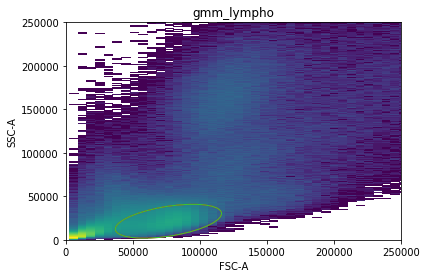

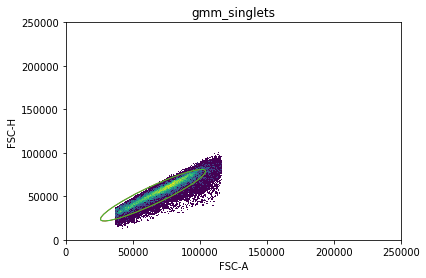

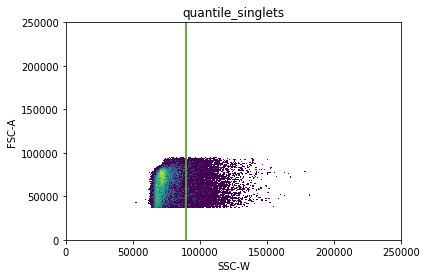

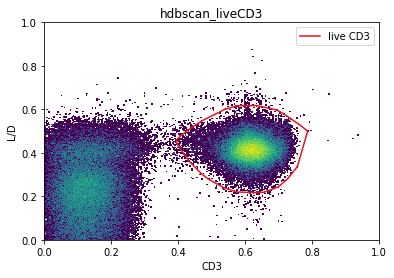

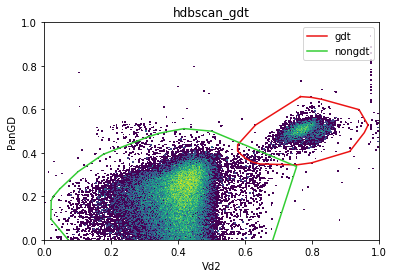

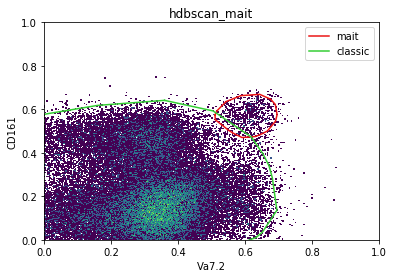

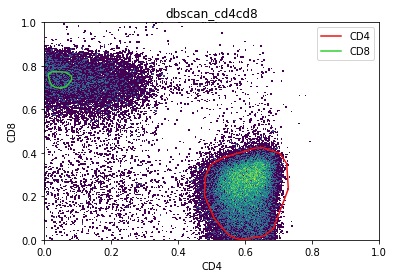

In [78]:
pdt.apply_many(apply_all=True, plot_outcome=True, feedback=True)

In [81]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('CD4', target=(0.6, 0.2), weight=1)
child_populations.add_population('CD8', target=(0.2, 0.7), weight=1)
gate_definition = dict(x='CD4', y='CD8', min_pop_size=100)
pdt.create_gate(gate_name='hdbscan_cd4cd8', parent='classic', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)

True

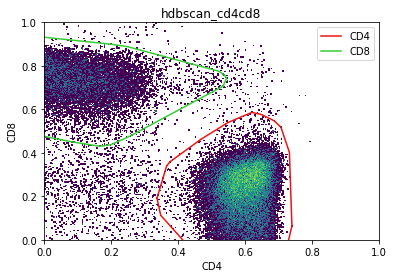

In [82]:
pdt.apply('hdbscan_cd4cd8')

In [83]:
pdt.save()

Saved successfully!


True

Applying gmm_lympho...
Applying gmm_singlets...
Applying quantile_singlets...
Applying hdbscan_liveCD3...
Applying hdbscan_gdt...
Applying hdbscan_mait...
Applying dbscan_cd4cd8...
Expected 2 populations but found 1
Populations f['CD4', 'CD8'] assigned to the same cluster 0;prioritising CD4 based on weighting.
Population CD8 has no associated gate, skipping...
Complete!


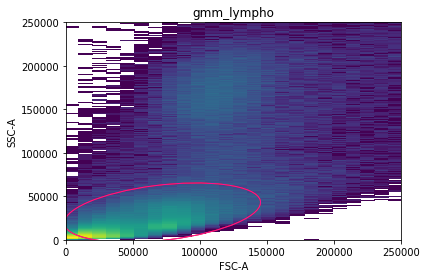

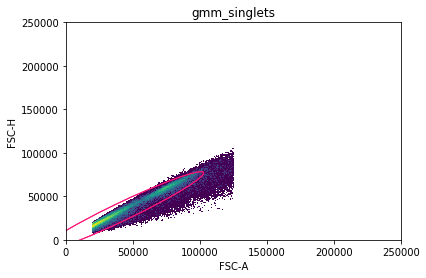

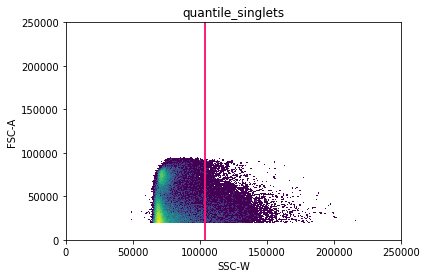

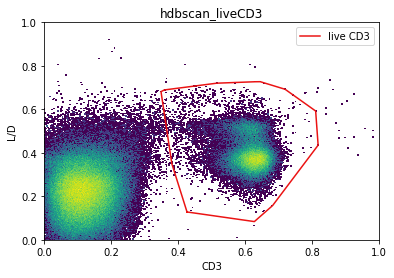

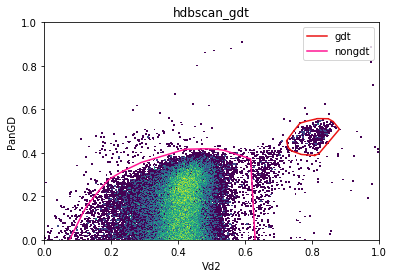

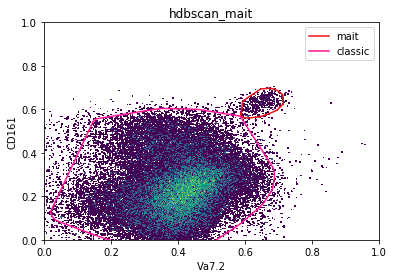

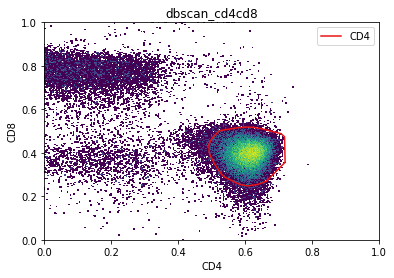

In [86]:
pdt = Template(t, '29403_stable_pbmc')
pdt.load_template('PD T Panel')
pdt.apply_many(apply_all=True, plot_outcome=True, feedback=True)

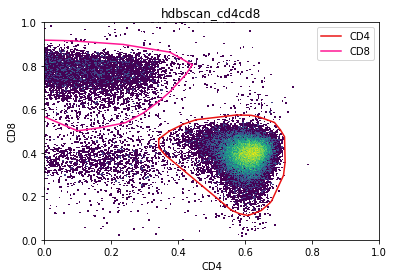

In [89]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('CD4', target=(0.6, 0.2), weight=1)
child_populations.add_population('CD8', target=(0.2, 0.7), weight=1)
gate_definition = dict(x='CD4', y='CD8', min_pop_size=100)
pdt.create_gate(gate_name='hdbscan_cd4cd8', parent='classic', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('hdbscan_cd4cd8')

In [90]:
pdt.save()

Saved successfully!


True